# 02E. Bifurcation

### Mingyang Lu

### 12/21/2023

# Intro

Let us continue our discussion on the circuit of one self-activating gene (Equations (7) - (8) in Part 2A). When we vary the values of $k$, as we learned from Part 2D, the circuit can have either one steady state (monostable) or three steady states (bistable as there are two stable states). To get a more complete picture of the system, we consider $k$ as a control parameter, and plot the curve of steady states $X_s$ as the function of $k$. This is called 1-dimensional bifurcation diagram. Let us discuss how we obtain such as curve numerically. We consider the following rate equation with $X$ as the state variable and $k$ as the control parameter.

$$\frac{dX}{dt} = f(X,k) = 10 + 45\frac{X^4}{X^4+200^4} - kX$$

In [1]:
def derivs_k(X, k):
    return 10 + 45 * (1- 1/(1+(X/200)**4)) - k*X

# Method 1: Seperation of variables

In this special case, along the bifurcation curve, $k$ can be expressed as a function of $X$:

$$ k = \frac{10}{X} + 45\frac{X^3}{X^4+200^4} $$

We can plot the curve numerically as follows.

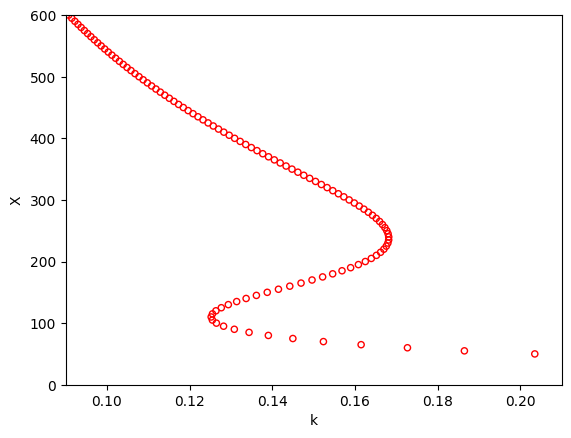

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def func_k(X):
    return 10 / X + 45 * X**3 / (X**4 + 200**4)

# Generate the range of X values (note that avoid X = 0)
X_all = np.arange(50, 605, 5) 

# Compute k_all values
k_all = func_k(X_all)

# Plot the function
plt.scatter(k_all, X_all, facecolors='none', edgecolors='red', s=20)
plt.xlabel("k")
plt.ylabel("X")
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.show()

The bifurcation curve clearly shows how the dynamical behavior of the circuit changes with respect to the changes in $k$. There are two turning points of the bifurcation curve. The first one is at around $k = 0.125$, where one of the stable steady states and the unstable steady state has very close $X$ values. The second one is at around $k = 0.170$. These two points are called bifurcation points. The system is monostable when $k$ is smaller than the $k$ value of the first bifurcation point. In this regime, the $X$ steady state level is relatively high. When $k$ is between the $k$ values of the two bifurcation points, the system is bistable, with two stable steady states of both high and low $X$ levels. When $k$ is higher than the $k$ value of the second bifurcation point, the system becomes monostable again, with one stable steady state of relatively low $X$ level. This type of bifurcation is called saddle-node bifurcation.

# Method 2: (direct method) find all roots
## Using fsolve function from scipy.optimize

The most straightforward way is to uniformly sample $k$ values and, for each $k$, identify all roots $X_s$ for $f(X,k)=0$. The following shows an implementation of such method using a Python library scipy.optimize. We also check stability of steady states according to $\frac{df}{dX}$. It works very well for this example. However, it may fail in some situations, as finding all roots for a nonlinear function s not guaranteed. Compared to other methods, this method should be slower but more stable. The implementation below uses a for loop, which clearly shows how it works.

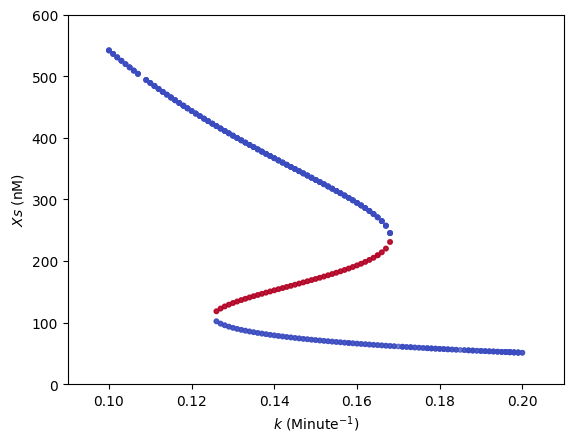

In [3]:
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore") # suppress a few warnings

# dx is used to estimate the derivatives of f(X) near the steady states
dx = 0.1

# All k values to be sampled (control parameter)
k_all = np.arange(0.1, 0.201, 0.001)

# Define a sufficiently large matrix to save k & steady states X
results = np.zeros((len(k_all) * 10, 3)) 

ind = 0
for k in k_all:
    # fsolve is used to find all roots by providing a vector of initial guesses
    roots = fsolve(derivs_k, x0=np.arange(50, 500, 50), args=(k,))
    # check each identified root
    for x in roots:
        # double check if the root is a steady state (abs(f) < 0.01)
        # This is added because fsolve may find wrong roots
        # uniroot.all in R seems to do a better job in finding all roots
        if abs(derivs_k(x, k)) > 0.01: 
            continue
        if 0 <= x <= 800:  # Filter out roots outside the interval [0, 800]
            if np.sign(derivs_k(X=x + dx, k=k)) < 0:  # df/dX < 0, stable
                stability = 1
            else:
                stability = 2
            results[ind] = [k, x, stability]
            ind += 1

results = results[:ind]

plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='coolwarm',
            marker='o', s=10, alpha=0.7)

plt.xlabel(r"$k$ (Minute$^{-1}$)")
plt.ylabel(r'$Xs$ (nM)')
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.show()

## Bisection method

We can numerically find the solutions of $X$ without using rootSolve. Below shows the implementation of the bisection method.


In [4]:
# Bisection method in Python
def bisection(f, interval, epsilon=1e-6, **kwargs):
    """
    Bisection method to find a root of the function f within the given interval.
    
    Parameters:
    f:  Function of f(x).
    interval: a vector containing the endpoints of the interval to be searched for the root.
    epsilon: Small positive number for the tolerance.
    **kwargs: Additional keyworded arguments to be passed to f.
        
    Returns:
        The root found within the interval or None if no root exists in the interval.
    """
    x_min = interval[0]
    f1 = f(x_min, **kwargs)
    x_max = interval[1]
    f2 = f(x_max, **kwargs)
    
    # Check if either endpoint is a root
    if abs(f1) < epsilon:
        return x_min
    if abs(f2) < epsilon:
        return x_max
    
    # Check if a root exists in the interval
    if f1 * f2 > 0:
        return None  # No root in the interval
    
    # Perform the bisection
    while f1 * f2 < 0:
        x_mid = (x_min + x_max) / 2
        f3 = f(x_mid, **kwargs)
        
        if abs(f3) < epsilon:
            return x_mid  # Found a root
        
        # Update interval endpoints based on the sign of f3
        if f1 * f3 > 0:
            f1 = f3
            x_min = x_mid
        else:
            f2 = f3
            x_max = x_mid

    return None  # Fail-safe (should not reach here)

# One solution
k = 0.12
root = bisection(lambda X: derivs_k(X, k), interval=(0, 600))
print(f"Root for k = {k}: {root}")

# Three solutions, but can only find one
k = 0.15
root = bisection(lambda X: derivs_k(X, k), interval=(0, 600))
print(f"Root for k = {k}: {root}")

# One solution
k = 0.2
root = bisection(lambda X: derivs_k(X, k), interval=(0, 600))
print(f"Root for k = {k}: {root}")


Root for k = 0.12: 443.431681394577
Root for k = 0.15: 331.6109240055084
Root for k = 0.2: 50.943151116371155


As shown above, the bisection method is a good method to find a root of a nonlinear function within a specified interval. If the signs of the function at two ends are different, there must be a root in the interval. However, if the signs at two ends are same, there might still be roots. but the bisection method can not find them. Newton's method is another choice, but it does not guarantee to find the root within the interval. Both methods can not find multiple roots.

### Find all roots using the bisection method

To find all roots, one needs to sample small intervals and then use bisection method to refine the solution.

In [5]:
def all_roots_bracketing(f, method, interval, resolution=1e-2, **kwargs):
    """
    Finds all roots of a function f within a specified interval using a root-finding method.

    Parameters:
    f: Function of f(x).
    method: Root-finding method (e.g., bisection or false position) that takes f, interval, and **kwargs as input.
    interval: a vector containing the endpoints of the interval to be searched for roots.
    resolution: Specifies the size of the search window as a fraction of the interval size.
    **kwargs: Additional keyworded arguments to be passed to f and the method.

    Returns:
        A list of unique roots found within the interval or None if no roots are found.
    """
    # Generate all x values for the sub-intervals
    x_all = np.linspace(interval[0], interval[1], int(1 / resolution) + 1)
    n_all = len(x_all) - 1
    root_all = []
    
    # Iterate over sub-intervals
    for i in range(n_all):
        root = method(f, (x_all[i], x_all[i + 1]), **kwargs)  # Apply the method to each sub-interval
        if root is not None:
            root_all.append(root)
    
    # Return unique roots or None if no roots are found
    if len(root_all) == 0:
        return None
    else:
        return np.unique(root_all).tolist()

### Find points along the curve

Application to find the curve of $f(X, k) = 0$.

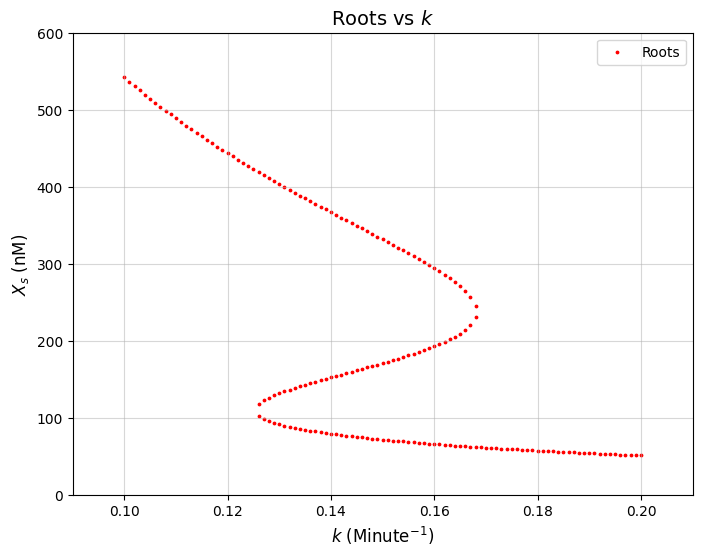

In [6]:
k_all = np.arange(0.1, 0.201, 0.001)  # all k grid points
results = np.zeros((len(k_all) * 3, 2))  # Assume at most 3 roots per k
ind = 0

# Main loop to find roots
for k in k_all:
    roots = all_roots_bracketing(lambda X: derivs_k(X, k), bisection, interval=(0, 600), resolution=1e-2)
    num_X = len(roots)
    if num_X > 0:
        results[ind:ind+num_X, 0] = k
        results[ind:ind+num_X, 1] = roots
        ind += num_X

# Trim the results matrix to remove unused rows
results = results[:ind, :]

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(results[:, 0], results[:, 1], color="red", s=3, label="Roots")
plt.xlabel(r"$k$ (Minute$^{-1}$)", fontsize=12)
plt.ylabel(r"$X_s$ (nM)", fontsize=12)
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.legend()
plt.grid(alpha=0.5)
plt.title("Roots vs $k$", fontsize=14)
plt.show()

But the found solutions are not aligned in the right sequence yet.

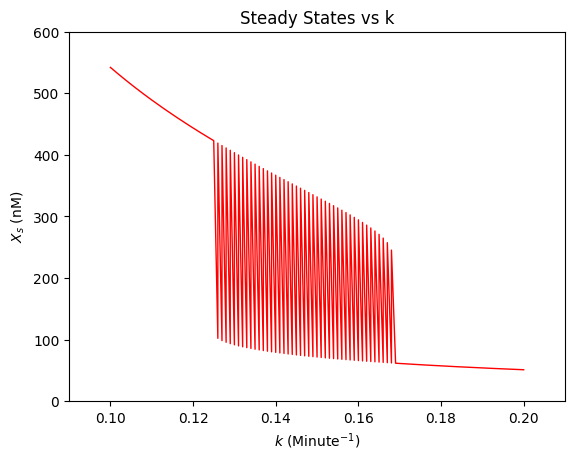

In [7]:
plt.plot(results[:, 0], results[:, 1], color='red', linewidth=1)
plt.xlabel(r"$k$ (Minute$^{-1}$)")  # LaTeX-style label for k
plt.ylabel(r"$X_s$ (nM)")           # Label for Xs
plt.xlim(0.09, 0.21)                # Set x-axis limits
plt.ylim(0, 600)                    # Set y-axis limits
plt.title("Steady States vs k")     # Optional title
plt.show()

### Reordering points along the curve

We can reorder the points in the right sequence by the following script. Here, we start from the leftmost point (with the smallest x value). Then, we iteratively find the closest unused point until all points are used.

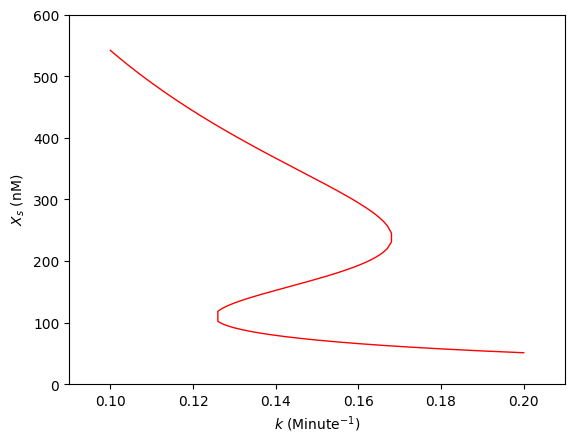

In [8]:
from scipy.spatial.distance import cdist
# Compute the pairwise distances of any two points
distances = cdist(results[:, :2], results[:, :2])  # Pairwise distances
m = 1 / distances  # Inverse distance values (infinity is handled later)
np.fill_diagonal(m, 0)  # Set self-distances to 0 to avoid divide-by-zero issues

# Initialize sequence and usage tracker
num_total = len(results)
sequence = np.zeros(num_total, dtype=int)  # To store the sequence of indices
if_unused = np.ones(num_total, dtype=bool)  # Boolean array to track unused points

# Start with the point having the minimum x value
ind_current = 0
point_current = np.argmin(results[:, 0])  # Find the index of the minimum x value
sequence[ind_current] = point_current
if_unused[point_current] = False

# Generate the sequence
while ind_current < num_total - 1:  # While not all indices are filled
    # Find the next closest unused point
    scores = m[:, point_current] * if_unused  # Multiply by `if_unused` to exclude used points
    point_current = np.argmax(scores)  # Find the index of the closest unused point
    ind_current += 1
    sequence[ind_current] = point_current
    if_unused[point_current] = False
   

# Plot the results in the sequence order
plt.plot(results[sequence, 0], results[sequence, 1], color='red', linewidth=1)
plt.xlabel(r"$k$ (Minute$^{-1}$)")  # LaTeX-style label for k
plt.ylabel(r"$X_s$ (nM)")           # Label for Xs
plt.xlim(0.09, 0.21)                # Set x-axis limits
plt.ylim(0, 600)                    # Set y-axis limits
plt.show()


## False position method

The false position method is almost the same as the bisection method. Instead of using the middle point, the false position method uses the x-intercept of the line connecting $f(x)$ at the endpoints of the interval. 

$$x_{new} = \frac{x_{min}f(x_{max}) - x_{max}f(x_{min})}{f(x_{max})-f(x_{min})}$$

The false position method can be faster than the bisection method. Both methods find a root within the specified interval.

In [9]:
# False position method
def false_position(f, interval, epsilon=1e-6, **kwargs):
    """
    False position method to find a root of the function f within the given interval.
    
    Parameters:
    f:  Function of f(x).
    interval: a vector containing the endpoints of the interval to be searched for the root.
    epsilon: Small positive number for the tolerance.
    **kwargs: Additional keyworded arguments to be passed to f.
        
    Returns:
        The root found within the interval or None if no root exists in the interval.
    """
    x_min, x_max = interval
    f1, f2 = f(x_min, **kwargs), f(x_max, **kwargs)
    
    # Check if the endpoints are roots
    if abs(f1) < epsilon:
        return x_min
    if abs(f2) < epsilon:
        return x_max
    # If f1 and f2 have the same sign, return None (no root in the interval)
    if f1 * f2 > 0:
        return None
    
    # Iteratively refine the root using the false position method
    while abs(x_max - x_min) > epsilon:
        # Compute the new estimate using the false position formula
        x_new = (f2 * x_min - f1 * x_max) / (f2 - f1)
        f3 = f(x_new, **kwargs)
        
        # Check if the new estimate is sufficiently close to a root
        if abs(f3) < epsilon:
            return x_new
        
        # Update the interval based on the signs of the function values
        if f1 * f3 > 0:
            x_min, f1 = x_new, f3
        else:
            x_max, f2 = x_new, f3

    return x_new

k = 0.12
root_1 = false_position(lambda X: derivs_k(X, k), interval=(0, 600))
print(f"Root for k = 0.12: {root_1}")

k = 0.15
root_2 = false_position(lambda X: derivs_k(X, k), interval=(0, 600))
print(f"Root for k = 0.15: {root_2}")

k = 0.2
root_3 = false_position(lambda X: derivs_k(X, k), interval=(0, 600))
print(f"Root for k = 0.2: {root_3}")

Root for k = 0.12: 443.4316871700353
Root for k = 0.15: 71.48399614234535
Root for k = 0.2: 50.94315317621584


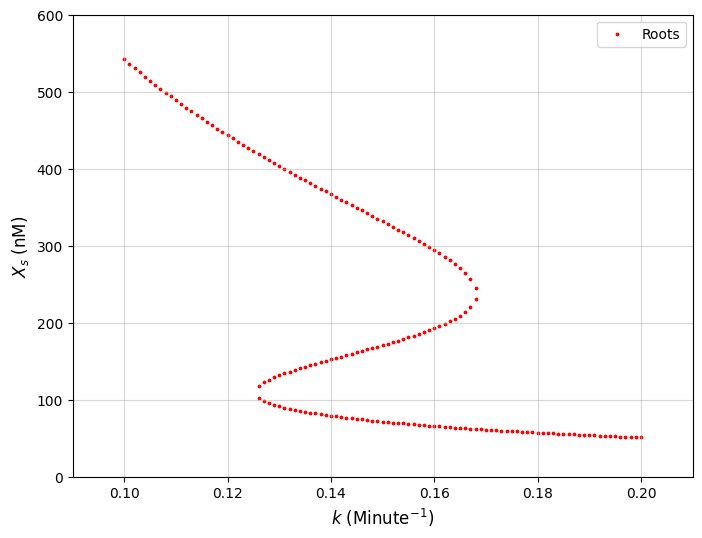

In [10]:
k_all = np.arange(0.1, 0.201, 0.001)  # all k grid points
results = np.zeros((len(k_all) * 3, 2))  # Assume at most 3 roots per k
ind = 0

# Main loop to find roots
for k in k_all:
    roots = all_roots_bracketing(lambda X: derivs_k(X, k), false_position, interval=(0, 600), resolution=1e-2)
    num_X = len(roots)
    if num_X > 0:
        results[ind:ind+num_X, 0] = k
        results[ind:ind+num_X, 1] = roots
        ind += num_X

# Trim the results matrix to remove unused rows
results = results[:ind, :]

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(results[:, 0], results[:, 1], color="red", s=3, label="Roots")
plt.xlabel(r"$k$ (Minute$^{-1}$)", fontsize=12)
plt.ylabel(r"$X_s$ (nM)", fontsize=12)
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Method 3: Get bifurcation curve by simulations

Start:
* Initial $k = k_1 = 0.1$.
* A random initial condition of $X = X_0$.
* Initial direction to sample $k$: increasing ($d_1 = 1$)
* $i = 1$

While $k_i < 0.2$:  (An iteration)
1. From the initial condition $X_{i-1}$, simulate $\frac{dX}{dt} = d_i f(X, k_i)$ until a stable steady state $X_i$ is reached.
2. Record $k_i$ and $X_i$.
3. If $i \ne 1$ AND $X_i$ is very different from $X_{i-1}$:

   $d_{i+1} = -d_i$ (A bifurcation point is reached, reverse direction to sample $k$).
4. $k_{i+1} = k_i + d_{i+1} \Delta k$. (Next $k$)
5. $i = i + 1$

In Step 1, when sampling along the reverse direction of $k$, $\frac{dX}{dt} = - f(X, k)$ will converge to an unstable steady state in the original ODE. 

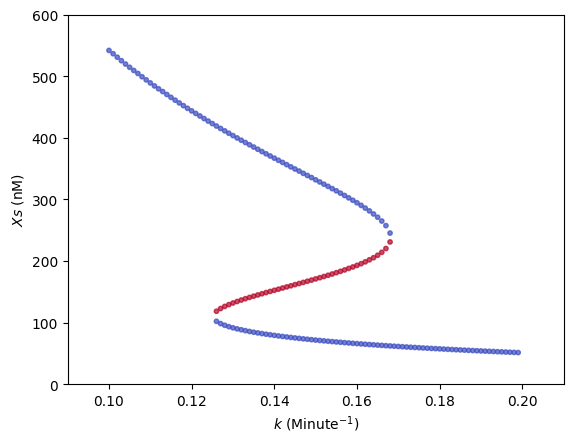

In [11]:
from scipy.integrate import solve_ivp

# Define the derivative function
def derivs_k_solve_ivp(t, X, k, d):
    # k: control parameter; d: 1 - stable steady state; 2 - unstable steady state
    return d * (10 + 45 * (1 - 1 / (1 + (X / 200)**4)) - k * X)

# Algorithm parameters
gap = 100.0      # the stop criterion for a bifurcation point
t_max = 1000.0   # Maximum ODE simulation time
dk = 0.001       # k step size 
dX = 1           # make a small step in X to estimate df/dX, a small step to perturbe X0 too

# Initialize parameters
k = 0.1
X0 = np.random.uniform(100, 600)  # Random initial condition of X
d = 1
ind = 0                 # Record the index of steady states

# Initialize results storage
results = np.full((1000, 3), np.nan)

while k < 0.2:
    # Simulate until a stable steady state is reached
    sol = solve_ivp(
        lambda t, X: derivs_k_solve_ivp(t, X, k, d),
        t_span=(0, t_max),
        y0=[X0],
        method='RK45'
    )
    Xi = sol.y.flatten()[-1]

    # Check for bifurcation point, switch the sampling direction of k.
    if ind > 0 and np.abs(Xi - X0) > gap:
        d = -d
        # Update k
        k = k + d * dk
        # Update X0, with slight perturbation along the same direction from X0 to Xi in the current step
        X0 = X0 + dX * np.sign(Xi - X0)
    else:
        # Determine stability of the steady state
        f_x_plus_dx = derivs_k_solve_ivp(0, Xi + dX, k, 1)
        stability = 1 if np.sign(f_x_plus_dx) < 0 else 2
        
        # record the steady state
        results[ind, :] = [k, Xi, stability]

        # Update k and the initial X for the next iteration
        k = k + d * dk
        X0 = Xi
        # Update iteration counter
        ind = ind + 1

# Print or plot the results as needed
plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='coolwarm',
            marker='o', s=10, alpha=0.7)
plt.xlabel(r"$k$ (Minute$^{-1}$)")
plt.ylabel(r'$Xs$ (nM)')
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.show()

In this implementation, solve_ivp is used to quickly find a stable steady state by an ODE simulation. To find unstable steady states, the derviative function needs to be reversed. Pay attention to the choice of the algorithm parameters, such as gap, t_max, and dX.

# Method 4. Contour method

## Using contour function

We define $z(x,y) := f(x,y)$, which generates a landscape $z$ for a plane of $x$ and $y$. The contour method finds the curve of $f(x, y) = 0$ by finding the contour line of $z = 0$. A typical contour algorithm requires the input of $f$ values for grid points of $x$ and $y$. See below for the implementation. Contour method is very powerful and stable. But it may fail to obtain the whole solution curve(s) if the solution has a branching structure. In this case, our function $f(X, k)$ is a function of $X$ and $k$.

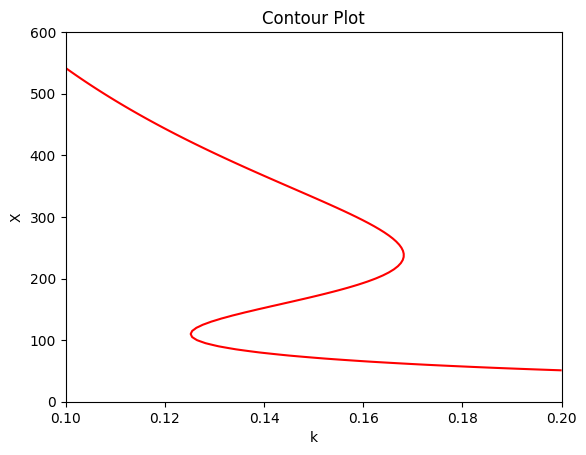

In [12]:
from itertools import product

# Parameters
k_all = np.arange(0.1, 0.2 + 0.001, 0.001)  # all k grids
X_all = np.arange(0, 600 + 5, 5)           # all X grids
nk = len(k_all)
nx = len(X_all)

# Generate all combinations of k and X
kx_all = np.array(list(product(k_all, X_all)))

# Calculate derivatives for all combinations
results = np.array([(*Xs, derivs_k(Xs[1], Xs[0])) for Xs in kx_all])

# Reshape the results into a 2D array for contour plotting
z = results[:, 2].reshape(nk, nx)

# Plot contour
plt.contour(k_all, X_all, z.T, levels=[0], colors='red')  # levels=[0] for contour at derivative=0
plt.xlabel("k")
plt.ylabel("X")
plt.title("Contour Plot")
plt.show()

## Implementation of bilinear interpolation

In [13]:
def contour_segment_bilinear(x_all, y_all, z, ind_x, ind_y, npoints=20):
    """
    Generate contour segment points using bilinear interpolation.

    Parameters:
    x_all: x grid points.
    y_all: y grid points.
    z : Matrix of f(x, y).
    ind_x: x index of the square (ind_x, ind_x+1).
    ind_y: y index of the square (ind_y, ind_y+1).
    npoints: Max number of points along the contour line for each square.

    Returns:
        Matrix containing contour points or None if no contour exists.
    """
    f11 = z[ind_x, ind_y]
    f21 = z[ind_x + 1, ind_y]
    f12 = z[ind_x, ind_y + 1]
    f22 = z[ind_x + 1, ind_y + 1]
    
    all_points = np.array([f11, f21, f12, f22])
    
    # Check if all points have the same sign
    if len(np.unique(np.sign(all_points))) == 1:
        # All the same sign, no solution
        return None
    else:
        x1, x2 = x_all[ind_x], x_all[ind_x + 1]
        y1, y2 = y_all[ind_y], y_all[ind_y + 1]
        
        # Sample x points
        x_points = np.linspace(x1, x2, npoints)
        
        # Interpolate f(x, y1) and f(x, y2)
        f_x_y1 = (x2 - x_points) * f11 + (x_points - x1) * f21  # Equation (4)
        f_x_y2 = (x2 - x_points) * f12 + (x_points - x1) * f22  # Equation (4)
        
        # Compute y points using equation (5)
        y_points = (f_x_y1 * y2 - f_x_y2 * y1) / (f_x_y1 - f_x_y2)
        
        # Keep points where y is within (y1, y2)
        ind_keep = np.where((y_points - y1) * (y2 - y_points) > 0)[0]
        points_keep = np.column_stack((x_points[ind_keep], y_points[ind_keep]))
        
        # Return contour points as a flattened array
        return points_keep.flatten() if points_keep.size > 0 else None


The following shows the application to $f(X,k)$ for a circuit with a self-activating gene. 

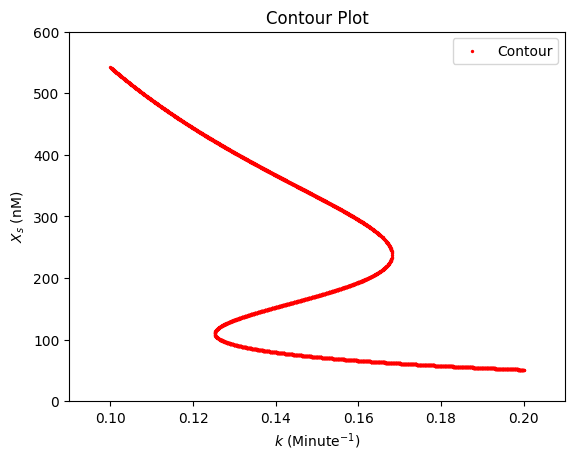

In [14]:
# Parameters
k_all = np.arange(0.1, 0.2 + 0.001, 0.001)  # All k grids
X_all = np.arange(0, 600 + 5, 5)           # All X grids
nk = len(k_all)
nx = len(X_all)

# Generate all combinations of k and X
kx_all = np.array(list(product(k_all, X_all)))

# Generate all vector field data
results = np.apply_along_axis(
    lambda Xs: np.array([Xs[0], Xs[1], derivs_k(Xs[1], Xs[0])]),
    axis=1,
    arr=kx_all
)

# Reshape results into a grid
z = results[:, 2].reshape(nk, nx)

# Define indices for k and X to specify squares
ind_k_all = np.arange(nk - 1)  # k indices
ind_X_all = np.arange(nx - 1)  # X indices

# Generate all combinations of indices
ind_kx_all = np.array(list(product(ind_k_all, ind_X_all)))

# Generate contour segments
results = [
    contour_segment_bilinear(x_all=k_all, y_all=X_all, z=z, ind_x=ind_kx[0], ind_y=ind_kx[1])
    for ind_kx in ind_kx_all
]

# Flatten and filter out None results
null_contour = np.vstack([res.reshape(-1, 2) for res in results if res is not None])

# Plot the results
plt.scatter(
    null_contour[:, 0], null_contour[:, 1],
    color="red", s=2, label="Contour"
)
plt.xlabel(r"$k$ (Minute$^{-1}$)")
plt.ylabel(r"$X_s$ (nM)")
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.title("Contour Plot")
plt.legend()
plt.show()



## Method 5: numerical continuation

Starting from a steady state $X$ for a specific $k$, we can obtain the slope of the bifurcation curve $\frac{dX}{dk}$ from

$$ \frac{dX}{dk} \equiv h(X,k) = -\frac{\frac{\partial f}{\partial k}}{\frac{\partial f}{\partial X}}$$

This allows us to find the initial guess of the next ($k$, $X$) point. 

\begin{cases} k_{new} = k + \Delta k \\
              X_{new} = X +  \frac{dX}{dk}\Delta k  \end{cases}

We can then use a correction method, such as Newton's method, to find the nearby solution.

### Newton's method
We solve $f(X) = 0$ starting from an initial guess at $X_0$. 

$$f(X_0 + \Delta X) = f(X_0) + f'(X_0)\Delta X = 0$$

Thus,

$$\Delta X = - \frac{f(X_0)}{f'(X_0)}$$
Numerically, we perform the following calculation iteratively:

$$ X_{n+1} = X_n - \frac{f(X_n)}{f'(X_n)} $$
, until $|f(X_{n+1})|<\epsilon$, where $\epsilon$ is a small constant. Below shows the implementation of Newton's method for the current system.

In [15]:
def dfdX(X, k):
    x_frac = (X / 200)**4
    return 180/X*x_frac / (1 + x_frac)**2 - k
    
# Implementation of the Newton's method to find a root of func
def find_root_Newton(X, func, dfunc, X_range, error=1e-3, **kwargs):
    # X: Initial guess of X
    # func: function f(X, ...)
    # dfunc: df/dX
    # X_range: lower and upper limits of root X. If X is outside of the range, the algorithm stops.
    f = func(X, **kwargs)
    
    while abs(f) > error:
        X = X - f / dfunc(X, **kwargs)
        
        # Check if X is within X_range
        if (X - X_range[0]) * (X - X_range[1]) > 0:
            break  # This would avoid a potential infinite loop; Newton's method doesn't converge.

        f = func(X, **kwargs)

    return X

# Example usage:
result1 = find_root_Newton(500, derivs_k, dfdX, (0, 800), k=0.1)
result2 = find_root_Newton(500, derivs_k, dfdX, (0, 800), k=0.15)
result3 = find_root_Newton(100, derivs_k, dfdX, (0, 800), k=0.15)
result4 = find_root_Newton(150, derivs_k, dfdX, (0, 800), k=0.15)

print("Root 1:", result1)  # monostable, one root
print("Root 2:", result2)  # bistable, first root near 500
print("Root 3:", result3)  # another root near 100
print("Root 4:", result4)  # the last root (unstable) near 150

Root 1: 541.796669343347
Root 2: 331.6144000103257
Root 3: 71.48399192899628
Root 4: 170.74655007005157


In [16]:
### Continuaton method

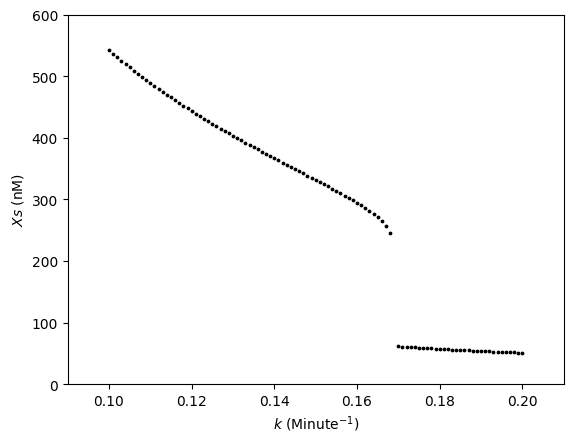

In [17]:
# Define the partial derivative df/dk; dfdX was defined earlier
def dfdk(X, k):
    return -X

# Algorithm parameters
X_init = 0  # Initial condition of X
k_range = np.array([0.1, 0.2])  # Range of parameter k
dk = 0.001  # Step size for parameter k
d = 1
nmax_cycle = int((k_range[1] - k_range[0]) / dk) + 1  # Maximum number of cycles

results = np.empty((nmax_cycle, 3))  # Create a matrix to store results
cycle = 0
k = 0.1

# Obtain the initial steady-state X using an ODE solver
sol = solve_ivp(
    lambda t, X: derivs_k_solve_ivp(t, X, k, d),
    t_span=(0, t_max),
    y0=[X_init],
    method='RK45'
)
X_new = sol.y.flatten()[-1]


results[cycle, :] = [k, X_new, -np.sign(dfdX(X_new, k))]

while (k_range[0] <= k <= k_range[1]):  # Check if k is in the range of [k_min, k_max]
    slope = -dfdk(X_new, k) / dfdX(X_new, k)  # Compute the slope of the bifurcation curve (Equation 4)
    # In this implementation, slope can be infinity near a bifurcation point
    k += dk
    X_init = X_new + dk * slope

    # Correction using Newton's method
    X_new = find_root_Newton(X=X_init, func=derivs_k, dfunc=dfdX, X_range=(0, 800), k=k)
    cycle += 1

    # Store results
    results[cycle, :] = [k, X_new, -np.sign(dfdX(X_new, k))]

# Plot the bifurcation diagram
plt.figure()
plt.xlabel(r'$k$ (Minute$^{-1}$)')
plt.ylabel(r'$Xs$ (nM)')
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.scatter(results[:, 0], results[:, 1], marker='o', s=3, color='black')
plt.show()

This algorithm doesn't work at the bifurcation point, where the the slope of the curve becomes infinity.

### Improved continuaton method using arc length

We describe the bifurcation curve as the function of arc length $s$, instead of the control parameter $k$. Previously we aim to find $X(k)$, but here we will find $X(s)$ and $k(s)$.

\begin{cases}   \Delta s^2 = \Delta k^2 + \Delta X^2 \\  \Delta X = h \Delta k  \end{cases}Therefore, we get\begin{cases} \Delta k = \pm \frac{1}{\sqrt{1 + h^2}} \Delta s \\              \Delta X = h \Delta k \end{cases},where $h(X,k) = \frac{dX}{dk}$. In this case, even when $h$ is infinity, $\Delta k$ and $\Delta X$ are small enough. The choice of $\pm$  would depend on which direction we want to go. Here, we set $(\Delta k, \Delta X)$ to be in the same direction as that in the previous step.

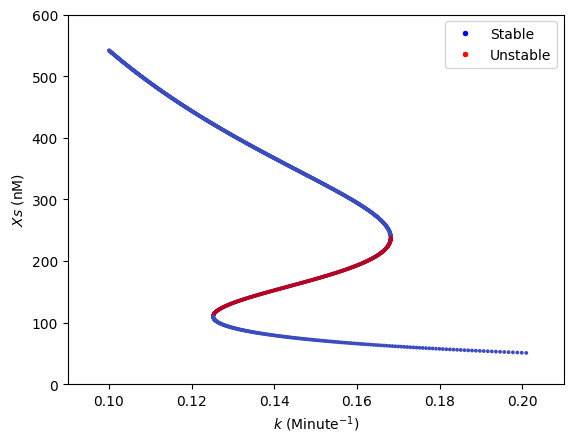

In [19]:
from matplotlib.lines import Line2D

# Algorithm parameters
X_init = 0  # Initial condition of X
k_range = [0.1, 0.2]  # Range of parameter k
ds = 0.3  # Step size for the arc length
nmax_cycle = 10000  # Maximum number of cycles

results = np.empty((nmax_cycle, 3))  # Create a matrix to store results
cycle = 0
k = 0.1
d = 1
step_k_previous = 1  # Initial step_k is positive
step_X_previous = 0

# Obtain initial steady-state X from ODE simulation
# Obtain the initial steady-state X using an ODE solver
sol = solve_ivp(
    lambda t, X: derivs_k_solve_ivp(t, X, k, d),
    t_span=(0, t_max),
    y0=[X_init],
    method='RK45'
)
X_new = sol.y.flatten()[-1]
results[cycle, :] = [k, X_new, -np.sign(dfdX(X_new, k))]

while ((k_range[0] <= k <= k_range[1]) and (cycle < nmax_cycle)):
    h = -dfdk(X_new, k) / dfdX(X_new, k)

    step_k = ds / np.sqrt(1 + h**2)
    step_X = step_k * h

    # The direction of change should be the same along the search
    if (step_k_previous * step_k + step_X_previous * step_X < 0):  
        step_k = -step_k
        step_X = -step_X

    step_k_previous = step_k
    step_X_previous = step_X

    k += step_k
    X_init = X_new + step_X

    # Correction using Newton's method
    X_new = find_root_Newton(X=X_init, func=derivs_k, dfunc=dfdX, X_range=(0, 800), k=k)

    cycle += 1
    results[cycle, :] = [k, X_new, -np.sign(dfdX(X_new, k))]

# Remove rows with NA values
results = results[~np.isnan(results).any(axis=1)]

# Plot the results
plt.figure()
plt.xlabel(r'$k$ (Minute$^{-1}$)')
plt.ylabel(r'$Xs$ (nM)')
plt.xlim(0.09, 0.21)
plt.ylim(0, 600)
plt.scatter(results[:, 0], results[:, 1], marker='o', c=(3 - results[:, 2]) / 2, cmap='coolwarm', s=3)
# Create custom legend labels and colors
legend_labels = ['Stable', 'Unstable']
legend_colors = ['blue', 'red']

# Create legend handles with custom labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=5) 
                  for label, color in zip(legend_labels, legend_colors)]

plt.legend(handles=legend_handles, loc='upper right')
plt.show()
